# Demonstration of OBIWAN-API

This is a quick demo of using the OBIWAN-API. The code here is not for production. No error handling code was added in this notebook.


## 1. Some helper functions

In [ ]:
import requests
from typing import Any
from enum import Enum

class ObiwanEndpoints(Enum):
  GET_STATE_MAP = "biomass_map"
  GET_CHANGE_MAP = "change_map"
  POST_STOCK_ESTIMATION = "estimate_biomass_state_geojson"
  POST_CHANGE_ESTIMATION = "estimate_biomass_change_geojson"
  POST_ANNUAL_ESTIMATION = "annual_biomass_state_geojson"

class ObiwanClient:
  def __init__(self, service_url):
    """
    Initialize the API client with a base URL.

    Parameters:
    base_url (str): The base URL for the API.
    """
    self.base_url = service_url

  def _get(self, endpoint, params=None):
    """
    Send a GET request to the API.

    Parameters:
    endpoint (str): The API endpoint.
    params (dict): The parameters to be sent in the query string (default is None).

    Returns:
    response (dict): The JSON response from the API.
    """
    url = f"{self.base_url}/{endpoint}"

    response = requests.get(url, params=params)
    return response.json()

  def _post(self, endpoint, json=None, headers=None):
    """
    Send a POST request to the API.

    Parameters:
    endpoint (str): The API endpoint.
    data (dict): The data to be sent in the body of the POST request (default is None).
    headers (dict): The headers to be sent with the POST request (default is None).

    Returns:
    response (dict): The JSON response from the API.
    """
    url = f"{self.base_url}/{endpoint}"
    response = requests.post(url, json=json, headers=headers)
    return response.json()

  def get_biomass_map(self, year: int, use_calibration:bool = False):
    return self._get(f"{ObiwanEndpoints.GET_STATE_MAP.value}/{year}",
                     params={"use_calibration": use_calibration})

  def get_change_map(self, start_year: int, end_year:int, use_calibration:bool = False):
    return self._get(f"{ObiwanEndpoints.GET_CHANGE_MAP.value}/{start_year}/{end_year}",
                  params={"use_calibration": use_calibration})

  def estimate_biomass_stock(self, year:int, aoi: Any, use_calibration:bool = False):
    return self._post(f"{ObiwanEndpoints.POST_STOCK_ESTIMATION.value}/{year}?use_calibration={use_calibration}",
                      json=aoi)

  def estimate_biomass_change(self, start_year:int, end_year:int, aoi: Any, use_calibration:bool = False):
    return self._post(f"{ObiwanEndpoints.POST_CHANGE_ESTIMATION.value}/{start_year}/{end_year}?use_calibration={use_calibration}",
                    json=aoi)

  def annual_biomass_stock(self, aoi: Any, use_calibration: bool = False):
    return self._post(f"{ObiwanEndpoints.POST_ANNUAL_ESTIMATION.value}?use_calibration={use_calibration}",
                    json=aoi)

## 2. Visualize OBIWAN Biomass Estimates


First we create a MapViewer which is used to visualize the map and also help to define an area of interest.


In [ ]:
from ipyleaflet import Map, TileLayer, basemaps, GeomanDrawControl

class MapViewer(Map):
    def __init__(self, center=(0,0), zoom=4, **kwargs):
        super().__init__(basemap=basemaps.OpenTopoMap,
                         center=center,
                         zoom=zoom,
                         **kwargs)

        self.draw_control = GeomanDrawControl()
        self.draw_control.polyline = {}
        self.draw_control.circlemarker = {}
        self.draw_control.rectangle = {}
        self.draw_control.polygon = {
            "pathOptions": {
                "fillColor": "#6be5c3",
                "color": "#6be5c3",
                "fillOpacity": 0.75
            }
        }

        super().add_control(self.draw_control)

    def get_aoi(self):
        return self.draw_control.data

In [ ]:
service_url = "https://obiwan-alabama-api-5026633953.us-west1.run.app"

# create a client object
client = ObiwanClient(service_url)

val = client.get_biomass_map(2021, True)
m = MapViewer(center=(32.897, -86.737), zoom=8, layout={'height': '800px'})
m.add_layer(TileLayer(url=val["url"]))

m


MapViewer(center=[32.897, -86.737], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

## 3. Biomass Estimation for Area of Interest

In [ ]:
import ipywidgets as widgets
from IPython.display import display

year_slider = widgets.IntSlider(
  value=2009,
  min=1999,
  max=2023,
  step=2,
  description='Year:',
  continuous_update=False
)

calibration_checkbox_biomass = widgets.Checkbox(
    value=False,
    description='with calibration',
    disabled=False
)

display(widgets.HBox([year_slider, calibration_checkbox_biomass]))

In [ ]:
import pandas as pd

aoi = {
  "type": "FeatureCollection",
  "features": []
}

aoi["features"] = m.get_aoi()

estimates = client.estimate_biomass_stock(year_slider.value, aoi, calibration_checkbox_biomass.value)

pd.DataFrame([estimates])

,AGBD,area,asset_version,stdAGBD,use_calibration,year
0,133.314197,4.753641e+08,1.0,11.047485,False,2021


## 4. Temporal Trend of Biomass

This shows the annual biomass change for the user defined area above. It uses Seaborn library for the scatter plot.

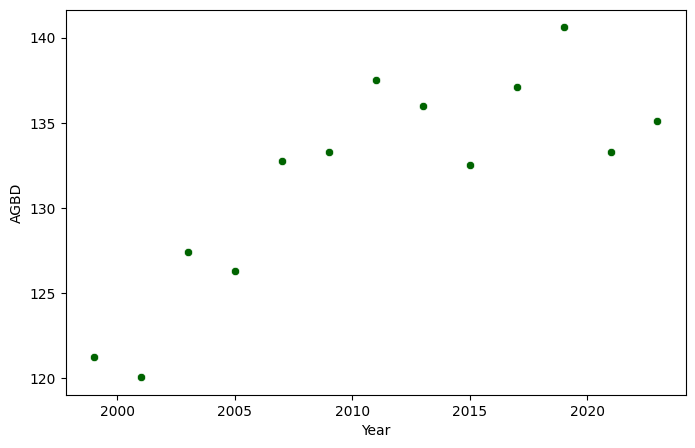

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

aoi = {
  "type": "FeatureCollection",
  "features": []
}

aoi["features"] = m.get_aoi()

estimates = client.annual_biomass_stock(aoi, calibration_checkbox_biomass.value)

estimates = pd.DataFrame(estimates)

plt.figure(figsize=(8,5))

sns.scatterplot(data=estimates, x="Year", y="AGBD", color="darkgreen", marker="o")

plt.show()


## 5. Change Estimation for Area of Interest

## 5.1. Single Temporal Window

In [ ]:
year_range = widgets.IntRangeSlider(
    value=[1999, 2023],
    min=1999,
    max=2023,
    step=2,
    description='Year Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='360px')
)

calibration_checkbox_change = widgets.Checkbox(
    value=True,
    description='with calibration',
    disabled=False
)

display(widgets.HBox([year_range, calibration_checkbox_change]))

In [ ]:
import pandas as pd

aoi = {
  "type": "FeatureCollection",
  "features": []
}

aoi["features"] = m.get_aoi()
start_year, end_year = year_range.value
use_calibration = calibration_checkbox_change.value
estimates = pd.DataFrame([client.estimate_biomass_change(start_year, end_year, aoi, use_calibration)])

estimates

,start_year,end_year,asset_version,use_calibration,area,dAGBD,stddAGBD
0,1999,2023,1.0,True,4.753641e+08,38.492509,5.086852


## 5.2. Counterfactual

For simplicity, in this simple simulation of counterfactual analysis, each polygon drawn is considered as a separate entity. In full application, user can define the comparison unit as they like multiple polygon, or using different existing area of interests.

In [ ]:
year_range = widgets.IntRangeSlider(
    value=[1999, 2023],
    min=1999,
    max=2023,
    step=2,
    description='Year Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='360px')
)

calibration_checkbox_change = widgets.Checkbox(
    value=True,
    description='with calibration',
    disabled=False
)

display(widgets.HBox([year_range, calibration_checkbox_change]))

In [ ]:
import pandas as pd

def counter_factual():
  aoi = {
    "type": "FeatureCollection",
    "features": []
  }

  aois = m.get_aoi()

  start_year, end_year = year_range.value
  use_calibration = calibration_checkbox_change.value

  result = pd.DataFrame()

  for idx, aoi_item in enumerate(aois):
    aoi["features"] = [aoi_item]
    estimates = pd.DataFrame([client.estimate_biomass_change(start_year, end_year, aoi, use_calibration)])
    estimates["ID"] = idx + 1

    result = pd.concat([result, estimates])

  return result

estimates = counter_factual()

estimates

,start_year,end_year,asset_version,use_calibration,area,dAGBD,stddAGBD,ID
0,1999,2023,1.0,True,4.753641e+08,38.492509,5.086852,1
0,1999,2023,1.0,True,9.316813e+08,43.279376,1.374747,2


## 5.3. Compare two Temporal Windows

In [ ]:
year_range1 = widgets.IntRangeSlider(
    value=[1999, 2005],
    min=1999,
    max=2023,
    step=2,
    description='First:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='360px')
)

year_range2 = widgets.IntRangeSlider(
    value=[2015, 2021],
    min=1999,
    max=2023,
    step=2,
    description='Second:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='360px')
)

calibration_checkbox_change = widgets.Checkbox(
    value=True,
    description='with calibration',
    disabled=False
)

display(widgets.HBox([widgets.VBox([year_range1, year_range2]), calibration_checkbox_change]))


In [ ]:
import pandas as pd

aoi = {
  "type": "FeatureCollection",
  "features": []
}

aoi["features"] = m.get_aoi()

use_calibration = calibration_checkbox_change.value

start_year1, end_year1 = year_range1.value
estimates1 = pd.DataFrame([client.estimate_biomass_change(start_year1, end_year1, aoi, use_calibration)])

start_year2, end_year2 = year_range2.value
estimates2 = pd.DataFrame([client.estimate_biomass_change(start_year2, end_year2, aoi, use_calibration)])


pd.concat([estimates1, estimates2])

,start_year,end_year,asset_version,use_calibration,area,dAGBD,stddAGBD
0,1999,2005,1.0,True,1.407045e+09,18.177207,1.313373
0,2015,2021,1.0,True,1.407045e+09,-1.811303,0.833101
